# Machine learning to perform 7-day forecast on covid-19 in US
<p> Considering daily differencing, which will normalize the data as well, we can determine what magnitude of ranges in feature interactions will be at risk each day. Then, looking at that date's data, we can categorize states into "in risk" or "no risk"

In [414]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
np.set_printoptions(precision=4,suppress=True, threshold=4)

In [415]:
# append csv file names into an empty list to be iterated through afterwards
import os

csv_list = []

for files in sorted(os.listdir("csse_covid19_daily_us/.")):
    if files.endswith(".csv"):
        csv_list.append(files)
        
print(len(csv_list))
csv_list[:5]

100


['04-12-2020.csv',
 '04-13-2020.csv',
 '04-14-2020.csv',
 '04-15-2020.csv',
 '04-16-2020.csv']

In [3]:
# look over one dataframe
apr12 = pd.read_csv('csse_covid19_daily_us/'+csv_list[0])

print(apr12.info())
print("\nLooking over unfamiliar names:", apr12.Province_State.unique(), sep='\n\n')
print("\nColumns with NaNs: ", apr12.isnull().sum(), sep='\n\n')

apr12.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Province_State        59 non-null     object 
 1   Country_Region        59 non-null     object 
 2   Last_Update           56 non-null     object 
 3   Lat                   56 non-null     float64
 4   Long_                 56 non-null     float64
 5   Confirmed             59 non-null     int64  
 6   Deaths                59 non-null     int64  
 7   Recovered             29 non-null     float64
 8   Active                59 non-null     int64  
 9   FIPS                  57 non-null     float64
 10  Incident_Rate         56 non-null     float64
 11  People_Tested         56 non-null     float64
 12  People_Hospitalized   49 non-null     float64
 13  Mortality_Rate        57 non-null     float64
 14  UID                   59 non-null     int64  
 15  ISO3                  59 

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-04-12 23:18:15,32.3182,-86.9023,3563,93,NaN,3470,1.0,75.988020,21583.0,437.0,2.610160,84000001,USA,460.300152,12.264945
1,Alaska,US,2020-04-12 23:18:15,61.3707,-152.4044,272,8,66.0,264,2.0,45.504049,8038.0,31.0,2.941176,84000002,USA,1344.711576,11.397059
2,Arizona,US,2020-04-12 23:18:15,33.7298,-111.4312,3542,115,NaN,3427,4.0,48.662422,42109.0,NaN,3.246753,84000004,USA,578.522286,NaN
3,Arkansas,US,2020-04-12 23:18:15,34.9697,-92.3731,1280,27,367.0,1253,5.0,49.439423,19722.0,130.0,2.109375,84000005,USA,761.753354,10.156250
4,California,US,2020-04-12 23:18:15,36.1162,-119.6816,22795,640,NaN,22155,6.0,58.137726,190328.0,5234.0,2.812020,84000006,USA,485.423868,22.961176


(59, 10)
           Confirmed      Deaths     Recovered         Active  People_Tested  \
count      59.000000    59.00000     29.000000      59.000000      56.000000   
mean     9412.084746   373.20339   2315.137931    8479.762712   50105.214286   
std     25898.520388  1256.83882   7350.913086   25229.041344   71442.430285   
min         0.000000     0.00000      0.000000  -32988.000000       3.000000   
25%       728.500000    17.50000     83.000000     712.000000   10866.500000   
50%      1970.000000    70.00000    236.000000    1874.000000   26651.500000   
75%      7617.500000   268.00000    493.000000    7301.500000   56374.500000   
max    189033.000000  9385.00000  32988.000000  179648.000000  461601.000000   

       Testing_Rate  People_Hospitalized  Mortality_Rate  \
count     56.000000            49.000000       57.000000   
mean     939.956205          1882.673469        3.177029   
std      520.114034          6122.105749        2.417004   
min        5.391708           

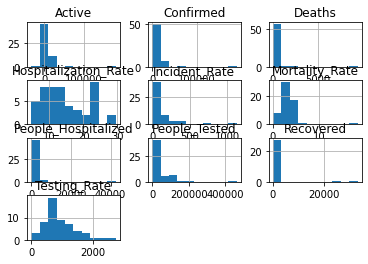

In [416]:
from pandas.plotting import scatter_matrix
from matplotlib import pyplot

# prep the April 12th dataset with columns of interest to summarize data
feature_cols = ['Confirmed', 'Deaths', 'Recovered', 'Active', 'People_Tested', 'Testing_Rate', 
                'People_Hospitalized', 'Mortality_Rate', 'Hospitalization_Rate', 'Incident_Rate']
apr12_ = apr12.loc[:, feature_cols]
# summarize the shape of the dataset
print(apr12_.shape)
# summarize each variable
print(apr12_.describe())
# histograms of the variables
apr12_.hist()
pyplot.show()

<p> Values vary in magnitude state by state, and it is difficult to gain much insight from unscaled data. Most of them, except for couple, are highly skewed. 
    
<p> Scaling will be necessary for our first part, which is to categorize data into "risk" or "no risk" based on feature interactions. This will be done per each date dataset, which then, will be fit into a model to train to perform as accurate prediction on which state is in category "risk" or "no risk". 
<hr>



                      Confirmed    Deaths  Recovered    Active  People_Tested  \
Confirmed              1.000000  0.991306   0.550863  0.985345       0.910503   
Deaths                 0.991306  1.000000   0.550580  0.974489       0.871627   
Recovered              0.550863  0.550580   1.000000  0.392786       0.971482   
Active                 0.985345  0.974489   0.392786  1.000000       0.912066   
People_Tested          0.910503  0.871627   0.971482  0.912066       1.000000   
Testing_Rate           0.510753  0.511333   0.592729  0.510486       0.443345   
People_Hospitalized    0.982544  0.990716   0.993716  0.981676       0.883377   
Mortality_Rate         0.122998  0.141672   0.327445  0.121988       0.044500   
Hospitalization_Rate   0.167469  0.180164   0.346958  0.166742       0.181944   
Incident_Rate          0.896644  0.882530   0.931017  0.896949       0.759640   

                      Testing_Rate  People_Hospitalized  Mortality_Rate  \
Confirmed                 0.51075

<AxesSubplot:>

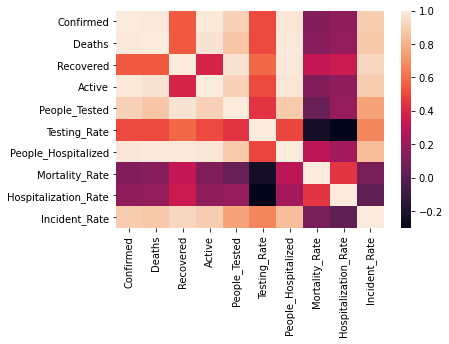

In [422]:
print(apr12_.corr())
sns.heatmap(apr12_.corr())


<AxesSubplot:xlabel='Incident_Rate'>

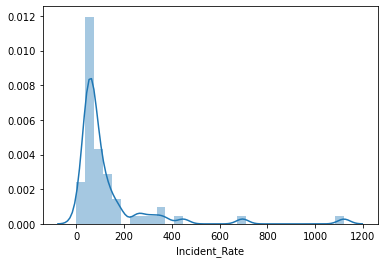

In [424]:

sns.distplot(apr12_.Incident_Rate)

<p> It's only one day, but just to review how our target data is distributed. It makes sense, and we can intuitively know that most of US datasets will be skewed due to differences in magnitude as well as outliers.
    
<p> Before we move on to loading all data and transforming them, we should scale just this day and quickly estimate how far we are from a manageable data.

In [438]:
# Standardize to bring mean to center.
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, Ridge, LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split

features = [cols for cols in apr12_ if cols != 'Incident_Rate']
# fill in nulls to avoid nan result
apr12_ = apr12_.fillna(0, axis=1)

# standard scaler and fit_transform to features
X_ex = StandardScaler().fit_transform(apr12_[features].astype(float))
# initiate linreg
y_ex = apr12_.Incident_Rate
lr = LinearRegression()
# convert to absolute value of mse and get avg from 50 cv.
mse = np.abs(cross_val_score(lr,X_ex,y_ex,cv=50,scoring='neg_mean_squared_error'))
rmsq = list(map(np.sqrt,mse))
print("50-fold mean RMSE: ", np.mean(rmsq))



50-fold mean RMSE:  65.37718712297388


<p> That's pretty high.
    
    
<p> Ok. Let's transform, aggregate and split, then evaluate step by step.

In [464]:
# quick assessment of feature 
coeffs = LinearRegression().fit(X_ex,y_ex).coef_
coeff_df = pd.DataFrame(list(zip(apr12_,np.abs(coeffs))),columns=["features","betas"])
coeff_df.sort_values("betas",ascending=False,inplace=True)
print(coeff_df, end='\n\n----------------------------------------\n\n')

# try PCA
pca = PCA()
transformed_pca_x = pca.fit_transform(apr12_[features])
#create component indices
component_names = ["component_"+str(comp) for comp in range(1, len(pca.explained_variance_)+1)]

#generate new component dataframe
transformed_pca_x = pd.DataFrame(transformed_pca_x,columns=component_names)
print(apr12_[features].head())
transformed_pca_x.head()

               features       betas
0             Confirmed  830.836127
3                Active  492.775756
6   People_Hospitalized  160.104519
2             Recovered  100.950318
4         People_Tested   67.215513
1                Deaths   56.309526
5          Testing_Rate   48.150592
7        Mortality_Rate    6.723868
8  Hospitalization_Rate    3.343040

----------------------------------------

   Confirmed  Deaths  Recovered  Active  People_Tested  Testing_Rate  \
0       3563      93        0.0    3470        21583.0    460.300152   
1        272       8       66.0     264         8038.0   1344.711576   
2       3542     115        0.0    3427        42109.0    578.522286   
3       1280      27      367.0    1253        19722.0    761.753354   
4      22795     640        0.0   22155       190328.0    485.423868   

   People_Hospitalized  Mortality_Rate  Hospitalization_Rate  
0                437.0        2.610160             12.264945  
1                 31.0        2.941176

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9
0,-26769.759281,-4399.390825,-826.631654,-77.648916,-373.043452,95.455773,-23.878753,1.068910,-0.714778
1,-40949.564995,-6255.560809,-521.173458,-293.176973,521.028282,-193.212821,-29.416386,-0.726462,0.542598
2,-8387.758151,4738.962749,-797.725162,127.213751,-190.211636,267.324143,81.934106,-9.304141,-0.221122
3,-29832.739353,-2389.359997,-324.238042,-346.879975,28.569660,173.686688,-6.507304,-0.042475,-0.812992
4,136706.267409,45490.579128,-1781.039234,-1315.099837,-856.989952,-943.948805,-113.228078,-9.157003,0.102100


component_1    0.965365
component_2    0.994729
component_3    0.999765
component_4    0.999946
component_5    0.999981
component_6    0.999999
component_7    1.000000
component_8    1.000000
component_9    1.000000
Name: explained_variance_ratio, dtype: float64

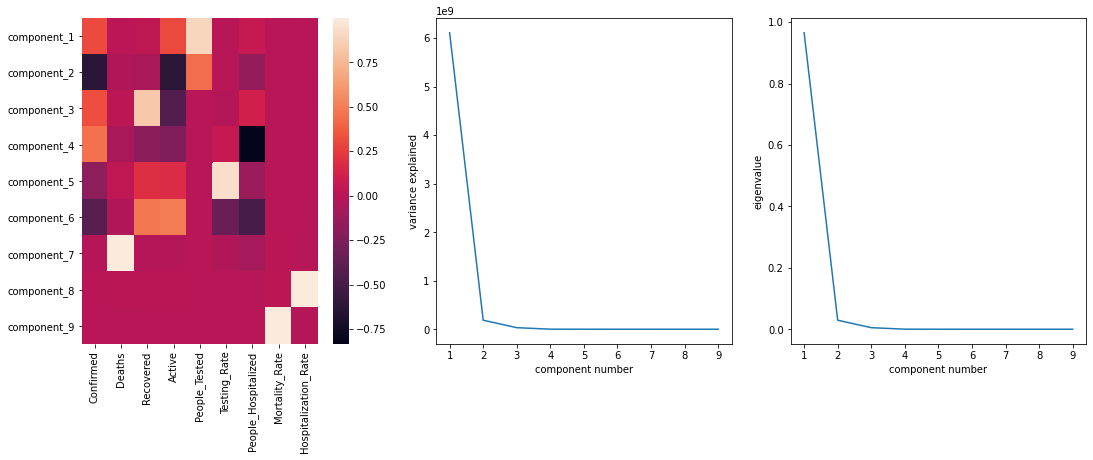

In [453]:
#generate component loadings on original features
component_matrix = pd.DataFrame(pca.components_,index=component_names,columns = features)
#add additional columns to describe what
component_matrix["explained_variance_ratio"] = pca.explained_variance_ratio_
component_matrix["eigenvalue"] = pca.explained_variance_
figure = sns.mpl.pyplot.figure(figsize=(18,6))
#add 3 subplots one at a time

#first the component matrix
figure.add_subplot(131)
sns.heatmap(component_matrix.iloc[:,:-2])

#then the eigenvalues
figure.add_subplot(132)
sns.mpl.pyplot.plot(range(1,component_matrix.shape[0]+1), component_matrix.eigenvalue)
sns.mpl.pyplot.xlabel("component number")
sns.mpl.pyplot.ylabel("variance explained")

#then the explained variance ratio
figure.add_subplot(133)
sns.mpl.pyplot.plot(range(1,component_matrix.shape[0]+1), component_matrix.explained_variance_ratio)
sns.mpl.pyplot.xlabel("component number")
sns.mpl.pyplot.ylabel("eigenvalue")
component_matrix.explained_variance_ratio.cumsum()

In [463]:

mean_squared_errors = np.abs(cross_val_score(lr,transformed_pca_x.iloc[:,:4],y_ex,cv=50,scoring='neg_mean_squared_error'))
#apply square root to each fold
root_mean_squared_errors = list(map(np.sqrt,mean_squared_errors))
print("50-fold mean RMSE: ", np.mean(root_mean_squared_errors))
print("50-fold std RMSE: ", np.std(root_mean_squared_errors))

transformed_pca_x.iloc[:,:4]


50-fold mean RMSE:  51.02708875411447
50-fold std RMSE:  70.38392426359594


['component_1',
 'component_2',
 'component_3',
 'component_4',
 'component_5',
 'component_6',
 'component_7',
 'component_8',
 'component_9']

<p> Trying out all combo of features, up to 4 components (confirmed, deaths, recovered and active) columns yield the lowest RMSE, although still pretty high. I want to continue evaluating with poly degree fitting

In [546]:

#generate the transformer
pf_2 = PolynomialFeatures(degree=2,interaction_only=True)
#apply it to the data, but ignore the first constant column
pf_2_data = pf_2.fit_transform(apr12_[features])[:,:4]#ignore constant column
print(pf_2_data.shape)
lr = LinearRegression()
#get the mean squared errors per fold, 10 fold cv
absolute_errors = np.abs(cross_val_score(lr,pf_2_data,apr12_['Incident_Rate'],cv=10))
#convert each fold's mean squared errors to rmse
rmses = list(map(np.sqrt,absolute_errors))
print("10-fold mean RMSE for degree-2 case: ",np.mean(rmses))


(59, 4)
10-fold mean RMSE for degree-2 case:  3.5783343478254666


<p> So much better! But this means that I should only use first two columns, Confirmed and Deaths.

In [549]:
pf_3 = PolynomialFeatures(degree=3,interaction_only=True)
#apply it to the data, but ignore the first constant column
pf_3_data = pf_3.fit_transform(apr12_[features])[:,:4]#ignore constant column
print(pf_3_data.shape)
lr = LinearRegression()
mean_squared_errors_poly3 = np.abs(cross_val_score(lr,pf_3_data,apr12_['Incident_Rate'],cv=10,scoring="neg_mean_squared_error"))
rmses_poly3 = list(map(np.sqrt,mean_squared_errors_poly3))
print("2-fold mean RMSE for degree-3 case: ",np.mean(rmses_poly3))

(59, 4)
2-fold mean RMSE for degree-3 case:  166.9470938025607


In [552]:
# Try lasso on this one date dataset
lasso = Lasso(max_iter=10000)#increase the number of iterations for lasso to prevent lack of convergence
mean_squared_errors_poly3_lasso = np.abs(cross_val_score(lasso,pf_3_data,apr12_['Incident_Rate'],cv=2))
rmses_lasso_poly3 = list(map(np.sqrt,mean_squared_errors_poly3_lasso))
print("2-fold mean RMSE for degree 3 case, strongest lasso regularization: ",np.mean(rmses_lasso_poly3))

2-fold mean RMSE for degree 3 case, strongest lasso regularization:  0.35745994451565094


<p> applying lasso with 3 degree case with 4 features, but just 2 cv folds, it brought down RMSE lowest so far to .3575, which is pretty cool.

In [548]:
# Finally, try ridge
ridge = Ridge()
ridge_cv_squared_errors = np.abs(cross_val_score(ridge,pf_2_data,apr12_['Incident_Rate'],cv=2))
rmse_ridge_cv = list(map(np.sqrt,ridge_cv_squared_errors))
print("3-fold mean RMSE for degree-2 case, strongest ridge regularization: ",np.mean(rmse_ridge_cv))


3-fold mean RMSE for degree-2 case, strongest ridge regularization:  0.35652642275227175


<p>Tried out using 4 features, 2 folds and ridge on pf2 data. Brought it further down to 0.3565, not bad. Let's move on

# Transform data into daily difference
Definitely drop cruise ships, as well as 'Recovered' in state rows. Use just first couple columns for now.

In [553]:
dropper_list = ['Diamond Princess', 'Grand Princess', 'Recovered']

feature_list = ['Province_State', 'Last_Update', 'Confirmed', 'Deaths', 
                'Recovered', 'Active', 'Incident_Rate']


def all_data_dict(filelist, state_filters, state_col):
    """Takes in a csv file string name,
    fills in missing date values with 'ffill' and 
    returns dataframes with column names lowercased 
    """ 
    daily_df = pd.concat({filelist[i][:-4]: 
                       pd.read_csv(''.join(['csse_covid19_daily_us/', filelist[i]]),
                      usecols=feature_list) for i in range(len(filelist))})

    daily_df.columns = daily_df.columns.str.lower()
    daily_df.rename(columns={state_col.lower(): 'state'}, inplace=True)
    daily_df.reset_index(level=[0,1], drop=True, inplace=True)
    

    return daily_df

allts = all_data_dict(csv_list, dropper_list, 'Province_State')

In [554]:
# Create a new dictionary of each state's ts
dateidx = pd.DatetimeIndex(dates[:-4] for dates in csv_list)
dropper_list = ['Diamond Princess', 'Grand Princess', 'Recovered']

state_dict = {}
for name, statedf in allts.groupby('state'):
    if name not in dropper_list:
        statedf_ = statedf.copy()
        statedf_.fillna(0, axis=1, inplace=True)
        
        statedf_.drop(columns=['last_update'], axis=1, inplace=True)
        statedf_['date'] = dateidx
        statedf_.set_index(['date'], inplace=True)
        state_dict[name] = statedf_
        
fix_meancol = ['confirmed', 'active']
statedf = pd.concat(state_dict)
statedf.reset_index(level=0,drop=True,inplace=True)
statedf.head()

,state,confirmed,deaths,recovered,active,incident_rate
date,,,,,,
2020-04-12,Alabama,3563,93,0.0,3470.0,75.988020
2020-04-13,Alabama,3734,99,0.0,3635.0,79.634933
2020-04-14,Alabama,3953,114,0.0,3839.0,84.305541
2020-04-15,Alabama,4075,118,0.0,3957.0,86.907433
2020-04-16,Alabama,4345,133,0.0,4212.0,92.665716


<p> Before we move on to coverting data into differences, there are few issues with Florida for some reason. One of them, I overrided in the above loop by substituting the date column with csv file names (since Florida's April 13th's date was submitted as midnight next day). The other issue with Florida's 4/13 values will be substituted with April 12, 14, and 15th mean values. 

In [555]:
# fix Florida's April 13th data
fix_meancol = ['incident_rate', 'active']
fl = statedf[statedf.state == 'Florida']
fl13 = statedf.loc[(statedf.index == '2020-04-13') & (statedf['state'] == 'Florida')]
#fl13_mort = fl13['deaths']/fl13['confirmed']*100
#statedf.loc[(statedf.index == '2020-04-13') & (statedf['state'] == 'Florida'), 'mortality_rate'] = fl13_mort

for i in range(len(fix_meancol)):
    colname = fix_meancol[i]
    statedf.loc[(statedf.index == '2020-04-13') 
                & (statedf['state'] == 'Florida'), colname] = np.mean([fl.loc[fl.index=='2020-04-12', colname], 
                                                                       fl.loc[fl.index=='2020-04-14', colname],
                                                                       fl.loc[fl.index=='2020-04-15', colname]])

statedf.loc[(statedf.index == '2020-04-13') & (statedf['state'] == 'Florida')]


,state,confirmed,deaths,recovered,active,incident_rate
date,,,,,,
2020-04-13,Florida,21019,499,0.0,20802.0,100.527776


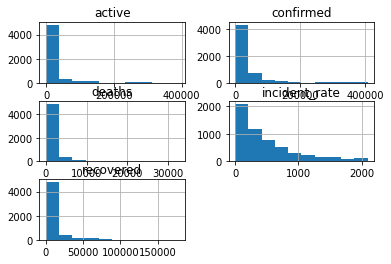

,state,confirmed,deaths,recovered,active,incident_rate
date,,,,,,
2020-04-12,Alabama,3563,93,0.0,3470.0,75.988020
2020-04-13,Alabama,3734,99,0.0,3635.0,79.634933
2020-04-14,Alabama,3953,114,0.0,3839.0,84.305541
2020-04-15,Alabama,4075,118,0.0,3957.0,86.907433
2020-04-16,Alabama,4345,133,0.0,4212.0,92.665716


In [557]:
statedf.iloc[:, 1:].hist()
pyplot.show()
statedf.head()

# Scaling

<p> With timeseries, we should test stationarity and decide which scaling method would be appropriate.

In [558]:
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit

# ADF test function [source: https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/]
def adf_test(ts):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfout = pd.Series(dftest[0:4], 
                      index=['Test Statistic','p-value',
                             '#Lags Used','Number of Observations Used'])
    for key, val in dftest[4].items():
        dfout['Critical Value (%s)'%key] = val
    print (dfout)


In [562]:
# Use an aggregated ts: median and mean
aggts_med = statedf.iloc[:, 1:].groupby(level='date').agg(np.median)
aggts_mean = statedf.iloc[:, 1:].groupby(level='date').agg(np.mean)

# stationary test with adf_test on target
adf_test(aggts_med.incident_rate)

# stationary test with adf_test on confirmed(feature)
adf_test(aggts_med.confirmed)

# stationary test with adf_test on target
adf_test(aggts_mean.incident_rate)

# stationary test with adf_test on confirmed(feature)
adf_test(aggts_mean.confirmed)

Results of Dickey-Fuller Test:
Test Statistic                  2.017403
p-value                         0.998695
#Lags Used                      3.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  1.226396
p-value                         0.996163
#Lags Used                      7.000000
Number of Observations Used    92.000000
Critical Value (1%)            -3.503515
Critical Value (5%)            -2.893508
Critical Value (10%)           -2.583824
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  1.931845
p-value                         0.998578
#Lags Used                      3.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
R

<p> Neither target nor feature(high impact column) is stationary, as expected.

Results of Dickey-Fuller Test:
Test Statistic                 -1.506267
p-value                         0.530409
#Lags Used                      3.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64


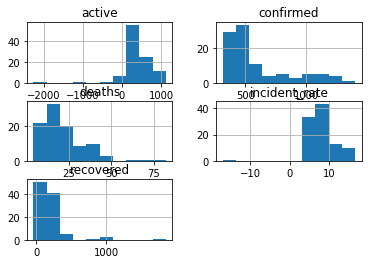

In [584]:
# get diff of each state for each day, then agg and use that agg data to test stationarity
statedif = {}
for statename, statedfs in statedf.groupby('state'):
    statedif[statename] = statedf[statedf.state==statename].iloc[:, 1:].diff().fillna(method='bfill')
diffagg = pd.concat(statedif).groupby(level='date').agg(np.mean)
    
# stationary test with adf_test on target
adf_test(diffagg['incident_rate'])

diffagg.hist()
pyplot.show()


<p> first differencing is not enough to rid non-stationarity. Data is still very skewed.

Results of Dickey-Fuller Test:
Test Statistic                 -1.506267
p-value                         0.530409
#Lags Used                      3.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64


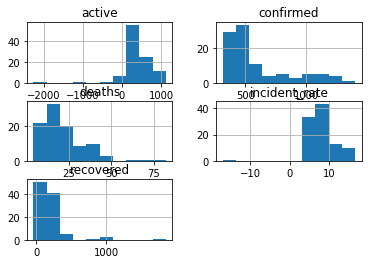

In [586]:
# 2nd diff
statedif2 = {}
for statename, statedfs in statedf.groupby('state'):
    statedif2[statename] = statedf[statedf.state==statename].iloc[:, 1:].diff().diff().fillna(method='bfill')
diff2agg = pd.concat(statedif).groupby(level='date').agg(np.mean)
    
# stationary test with adf_test on target
adf_test(diff2agg['incident_rate'])

diffagg.hist()
pyplot.show()

<p> 2nd differencing and aggregating all states to ts is still not adequate. Try other scaling

In [622]:
# log + 1
log1 = {}
for statename, statedfs in statedf.groupby('state'):
    statedfs_ = statedf[statedf.state==statename].iloc[:, 1:]
    for cols in statedfs_:
        statedfs_.loc[:, cols] = np.log1p(statedfs_[cols])
    log1[statename] = statedfs_

log1_agg = pd.concat(log1).groupby(level='date').agg(np.median)
adf_test(log1_agg.incident_rate)


Results of Dickey-Fuller Test:
Test Statistic                 -2.489536
p-value                         0.118041
#Lags Used                      2.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


/Users/jmaclvin/environments/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [634]:
# shuffle each day, set 10% aside and combine to set aside as a test set. fit with robust, then fit to test.
from sklearn.preprocessing import RobustScaler


# shuffled daily datasets split into train and test (10% from each day)
daily_train = {}
daily_test = {}
for dates, datedf in statedf.groupby(level='date'):
    datekey = str(dates)[:10]
    datedf_ = statedf[statedf.index==datekey].iloc[:,1:]
    shuffleday = shuffle(datedf_)
    # set last 7 row in each date data as final test set
    daily_train[datekey] = shuffleday[:-7]
    daily_test[datekey] = shuffleday[-7:]
    # set and fit rb scaler
    rbscaler = RobustScaler()
    rbscaler.fit(daily_train[datekey].iloc[:, :-1])
    # transform features
    daily_train[datekey].iloc[:, :-1] = rbscaler.transform(daily_train[datekey].iloc[:, :-1])
    daily_test[datekey].iloc[:, :-1] = rbscaler.transform(daily_test[datekey].iloc[:, :-1])
    
    
daily_train

/Users/jmaclvin/environments/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/jmaclvin/environments/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/jmaclvin/environments/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/Users/jmaclvin/environments/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/jmaclvin/environments/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/jmaclvin/environments/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/Users/jmaclvin/environments/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/jmaclvin/environments/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/jmaclvin/environments/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/Users/jmaclvin/environments/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/jmaclvin/environments/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/jmaclvin/environments/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/Users/jmaclvin/environments/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/jmaclvin/environments/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/jmaclvin/environments/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/Users/jmaclvin/environments/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/jmaclvin/environments/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/jmaclvin/environments/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/Users/jmaclvin/environments/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/jmaclvin/environments/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/jmaclvin/environments/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

{'2020-04-12':             confirmed     deaths   recovered     active  incident_rate
 date                                                                  
 2020-04-12  -0.189830  -0.256809    1.561702  -0.190456      49.439423
 2020-04-12   1.284265   1.793774    0.000000   1.253565     337.560483
 2020-04-12  -0.256853  -0.295720    0.000000  -0.258083      51.859603
 2020-04-12  -0.143092  -0.089494    3.582979  -0.148383      32.771004
 2020-04-12   0.015899   0.011673    0.000000   0.011718      96.055341
 2020-04-12  -0.265625  -0.256809    0.063830  -0.268530     119.064972
 2020-04-12  -0.155976  -0.159533    0.000000  -0.159113      38.107607
 2020-04-12  -0.096217   0.015564    1.974468  -0.103911      57.342280
 2020-04-12  -0.323054  -0.334630    0.514894  -0.324862      50.790049
 2020-04-12  -0.312226  -0.338521    0.719149  -0.313568      44.688893
 2020-04-12  -0.363761  -0.354086    0.000000  -0.366088      19.947773
 2020-04-12   2.957648   5.392996    1.842553   2.

In [653]:
adf_test(pd.concat(daily_train).groupby(level='date').incident_rate.agg(np.mean))
train = pd.concat(daily_train).reset_index(level=0, drop=True)

print('\n', train.describe())


Results of Dickey-Fuller Test:
Test Statistic                  1.642696
p-value                         0.997980
#Lags Used                      4.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64

          confirmed       deaths    recovered       active  incident_rate
count  4900.000000  4900.000000  4900.000000  4900.000000    4900.000000
mean      0.633514     0.888228     0.848364     0.881094     483.701903
std       2.131875     3.193556     3.565511     2.574308     462.101306
min      -0.587470    -0.424242    -0.470640    -0.520153       0.000000
25%      -0.279117    -0.219743    -0.219799    -0.269021     139.496918
50%       0.000000     0.000000     0.000000     0.000000     320.845076
75%       0.736430     0.787180     0.792551     0.739504     676.566858
max      25.543860    40.154867   109.573394    24.995906    2093.837730


# STOPPED HERE 08-06-2020: 
NEXT: 
* RMSE & MODEL EVALUATION

<br><br>
**ignore below**

In [182]:
# Create category mask column, add to train y

# find the low, high cut off percentile points
q1_, q3_ = np.percentile(y_pa.values, [25, 75])
iqr_ = q3_ - q1_
low = q1_ - 1.5 * iqr_
hi = q3_ + 1.5 * iqr_

print("min ir: {}".format(y_pa.min()))
#print(iqr_)
print((low, hi))
print(".25: {}, .75: {}".format(q1_, q3_), end='\n\n')


#state1diff2[state1diff2.incident_rate.values<-7.15999485]
low_outs = []
hi_outs = []
for x in list(range(101)):
    
    if np.percentile(y_pa.values, x) < low:
        low_outs.append(x)
    elif np.percentile(y_pa.values, x) > hi:
        hi_outs.append(x)
print(low_outs)
print(hi_outs)
#print(str(low_outs[-1])+"th percentile as low qcut")
#print(str(hi_outs[0])+"th percentile as high qcut")

min ir: 182.2284446
(43.98484597596405, 991.5634118565021)
.25: 399.3268081811658, .75: 636.2214496513003

[]
[]


<p> PA is an example dataset where there are no "risky" days. We'll just use numerical data for now.

In [570]:
decision_tree = DecisionTreeRegressor(max_depth=2)

#fit it using training data
decision_tree.fit(Xtrain_,ytrain_)

#evaluate the quality of the decision tree we created


print("Decision Tree RMSE:",np.sqrt(mean_squared_error(ytest_,decision_tree.predict(Xtest_))))



Decision Tree RMSE: 6.717344473122227


In [26]:
state1diff2['risk_group'] = pd.qcut(state1diff2.incident_rate, 
                                    q=[0.05, .97, 1.00], 
                                    labels=['no risk', 'in risk'])
print(state1diff2.info())
#apr1.sort_values(by='incident_rate')



#apr1['risk_group'] = pd.qcut(apr1.incident_rate, q=[0.00, 0.05, .97, 1.], labels=['no risk', 'in risk'])
state1diff2.risk_group.fillna('in risk', inplace=True)
print(state1diff2.isnull().sum())
state1diff2.head()
state1diff2['risk_bool_int'] = 0
state1diff2.loc[state1diff2.risk_group == 'in risk', 'risk_bool_int'] = 1
state1diff2.tail(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 80 entries, 2020-04-12 to 2020-06-30
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   confirmed             80 non-null     float64 
 1   deaths                80 non-null     float64 
 2   recovered             80 non-null     float64 
 3   active                80 non-null     float64 
 4   incident_rate         80 non-null     float64 
 5   people_tested         80 non-null     float64 
 6   mortality_rate        80 non-null     float64 
 7   testing_rate          80 non-null     float64 
 8   hospitalization_rate  80 non-null     float64 
 9   risk_group            76 non-null     category
 10  risk_bool_int         80 non-null     int64   
dtypes: category(1), float64(9), int64(1)
memory usage: 7.0 KB
None
confirmed               0
deaths                  0
recovered               0
active                  0
incident_rate           0
peo

,confirmed,deaths,recovered,active,incident_rate,people_tested,mortality_rate,testing_rate,hospitalization_rate,risk_group,risk_bool_int
date,,,,,,,,,,,
2020-06-21,-75.0,-15.0,0.0,-60.0,-1.529618,-3043.0,-0.042937,-62.061701,-0.010523,no risk,0
2020-06-22,-39.0,1.0,0.0,-40.0,-0.795401,-723.0,0.008089,-14.745517,-0.007028,no risk,0
2020-06-23,210.0,21.0,0.0,189.0,4.282930,496.0,0.050029,10.115874,0.073402,no risk,0
2020-06-24,324.0,4.0,2892.0,-2572.0,6.607950,-207.0,-0.016447,-4.221746,-0.094043,no risk,0
2020-06-25,175.0,-22.0,-2892.0,3089.0,3.569109,5978.0,-0.080924,121.920752,-0.038787,no risk,0
2020-06-26,-165.0,6.0,0.0,-171.0,-3.365160,-1834.0,0.035568,-37.404259,0.034934,no risk,0
2020-06-27,-77.0,1.0,0.0,-78.0,-1.570408,-3162.0,0.011078,-64.488695,0.031197,no risk,0
2020-06-28,-542.0,-12.0,0.0,-530.0,-11.054039,-3449.0,0.007403,-70.342033,0.012960,in risk,1
2020-06-29,1376.0,10.0,0.0,1366.0,28.063391,4759.0,-0.067590,97.059360,-0.235841,in risk,1


In [124]:
rf = RandomForestClassifier(n_estimators=50) #random forest with 50 trees
rf2 = RandomForestClassifier(max_depth=2, n_estimators=70) # add max depth
rf3 = RandomForestClassifier(max_depth=3, n_estimators=30)

i = 1

for train_idx, test_idx in tss.split(state1diff2_X):
    #print(train_idx, test_idx)
    Xtrain_, Xtest_ = state1diff2_X.iloc[train_idx, :], state1diff2_X.iloc[test_idx,:]
    ytrain_, ytest_ = state1_y.iloc[train_idx], state1_y.iloc[test_idx]

    rf_fit = rf3.fit(Xtrain_,ytrain_)
    print("Accuracy for split ",i,": ", metrics.accuracy_score(ytest_,
                                                               rf_fit.predict(Xtest_)))
    i += 1
    

   
    #print("Decision Tree RMSE:",np.sqrt(mean_squared_error(ytest_,
     #                                                      decision_tree
      #                                                     .predict(Xtest_))))

#compute cross-validation score accuracy across 10 folds
cross_val_scores = cross_val_score(rf3, state1diff2_X, state1_y, cv=tss, scoring='accuracy')
print("5-fold accuracies:\n",cross_val_scores)
print("Mean cv-accuracy:",np.mean(cross_val_scores))
print("Std of cv-accuracy:",np.std(cross_val_scores))

Accuracy for split  1 :  1.0
Accuracy for split  2 :  0.9230769230769231
Accuracy for split  3 :  0.9230769230769231
Accuracy for split  4 :  1.0
Accuracy for split  5 :  0.6923076923076923
5-fold accuracies:
 [1.     0.9231 1.     1.     0.6923]
Mean cv-accuracy: 0.9230769230769231
Std of cv-accuracy: 0.1191687183448436


#### Quick results review:

* rf2: md=2, ne=70 
    **mean cv-acc: .9375  |  std of cv-acc: .0395**
* rf3: md=3, ne=30 
    **mean cv-acc: .9375  |  std of cv-acc: 0.0**
    
Both had higher mean cv-acc than the first rf model

In [113]:
# Use grid search to iterate through md ranges
rf_grid = RandomForestClassifier(n_estimators=30,
                                 
                                 n_jobs=-1) #50 trees
max_depth_range = range(1, 11)
param_grid = dict(max_depth=max_depth_range)
print(param_grid)

grid = GridSearchCV(rf_grid,
                    param_grid,
                    cv=tss,
                    scoring='accuracy')
grid.fit(state1diff2_X, state1diff2.risk_group)

# examine the results of the grid search
grid.cv_results_

{'max_depth': range(1, 11)}


{'mean_fit_time': array([0.0693, 0.0538, 0.0551, ..., 0.0576, 0.0515, 0.0555]),
 'std_fit_time': array([0.0243, 0.0021, 0.0042, ..., 0.007 , 0.0027, 0.0108]),
 'mean_score_time': array([0.0113, 0.0105, 0.0113, ..., 0.0113, 0.0105, 0.0107]),
 'std_score_time': array([0.0018, 0.0006, 0.0018, ..., 0.0016, 0.0006, 0.0013]),
 'param_max_depth': masked_array(data=[1, 2, 3, ..., 8, 9, 10],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1},
  {'max_depth': 2},
  {'max_depth': 3},
  {'max_depth': 4},
  {'max_depth': 5},
  {'max_depth': 6},
  {'max_depth': 7},
  {'max_depth': 8},
  {'max_depth': 9},
  {'max_depth': 10}],
 'split0_test_score': array([1., 1., 1., ..., 1., 1., 1.]),
 'split1_test_score': array([0.9231, 0.9231, 0.9231, ..., 0.9231, 0.9231, 0.9231]),
 'split2_test_score': array([0.9231, 0.9231, 0.9231, ..., 0.9231, 0.9231, 0.9231]),
 'split3_test_score': array([1., 1., 1., ..., 1., 1., 

In [573]:
# Poly feature
from sklearn.preprocessing import PolynomialFeatures

polyfit_d2 = PolynomialFeatures(degree=2)
polyfitted_d2 = polyfit_d2.fit_transform(Xtrain_)